In [1]:
cd /home/ec2-user/SageMaker/brandClassification

/home/ec2-user/SageMaker/brandClassification


In [2]:
# import necessary libraries

import os
import tensorflow as tf
import numpy as np

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn
import cv2

import glob

In [3]:
# # Download Dataset

# !curl -L "https://app.roboflow.com/ds/bN0eTbcJa5?key=fvbRP7ESKe" > roboflow.zip; 
# !unzip roboflow.zip; rm roboflow.zip

## Data Visualization

In [4]:
train_dir = 'train'
test_dir = 'test'
# val_dir = 'Dataset/out/val'

In [5]:
cocacola_train_images = glob.glob(train_dir+"/cocacola/*.jpg")
lactania_train_images = glob.glob(train_dir+"/lactania/*.jpg")
ordinary_train_images = glob.glob(train_dir+"/ordinary/*.jpg")
pepsi_train_images = glob.glob(train_dir+"/pepsi/*.jpg")
starbucks_train_images = glob.glob(train_dir+"/starbucks/*.jpg")
# concat JPG and jpg other images

# others_train_images = glob.glob(train_dir+"/others/*.JPG")

# others_train_images3 = glob.glob(train_dir+"/others/*.png")

# others_concat_train_images = others_train_images1 + others_train_images2 + others_train_images3


In [6]:
a = len(cocacola_train_images)
b = len(lactania_train_images)
c = len(ordinary_train_images)
d = len(pepsi_train_images)
e = len(starbucks_train_images)
print(a)
print(b)
print(c)
print(d)
print(e)
print("Total Train Images: ",a + b + c + d + e)

459
407
346
451
477
Total Train Images:  2140


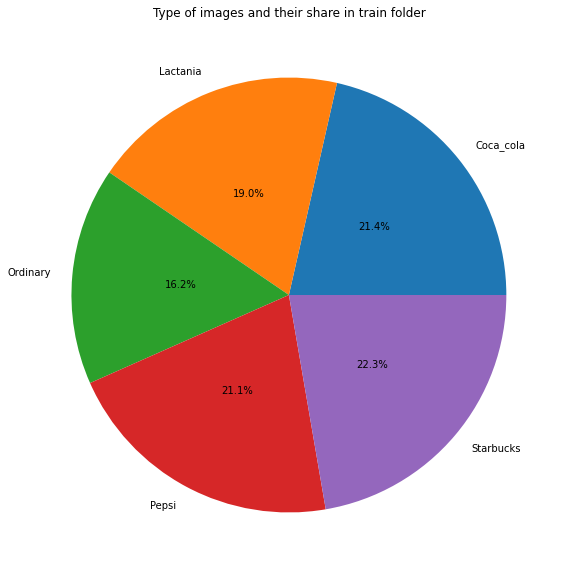

In [7]:
plt.figure(figsize=(15, 10))
plt.pie(x=np.array([len(cocacola_train_images), len(lactania_train_images), len(ordinary_train_images), len(pepsi_train_images), len(starbucks_train_images)]), autopct="%.1f%%", explode=[0,0,0,0,0], labels=["Coca_cola", "Lactania","Ordinary","Pepsi","Starbucks"], pctdistance=0.5)
plt.title("Type of images and their share in train folder", fontsize=12);

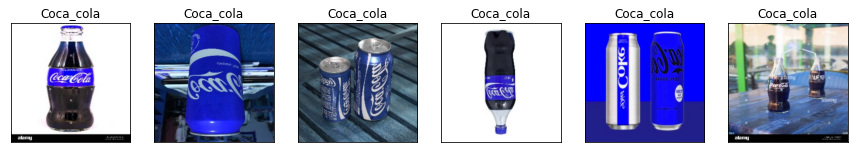

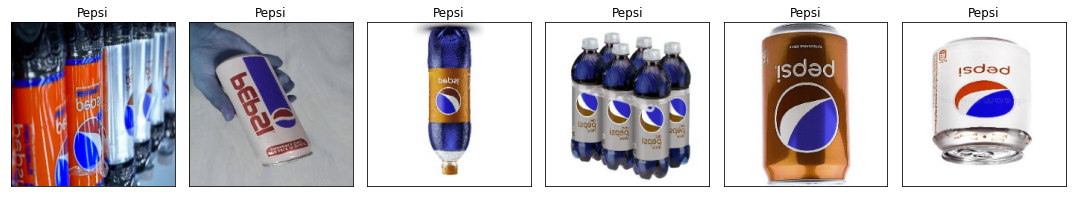

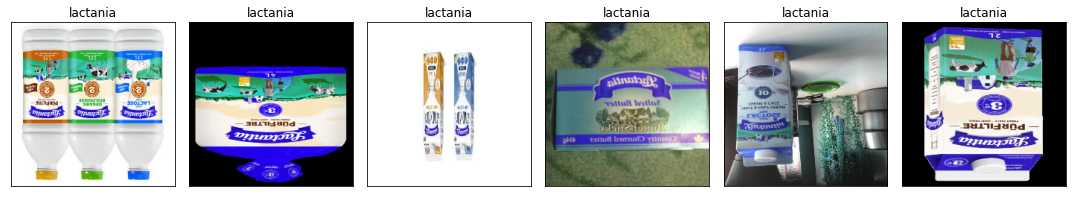

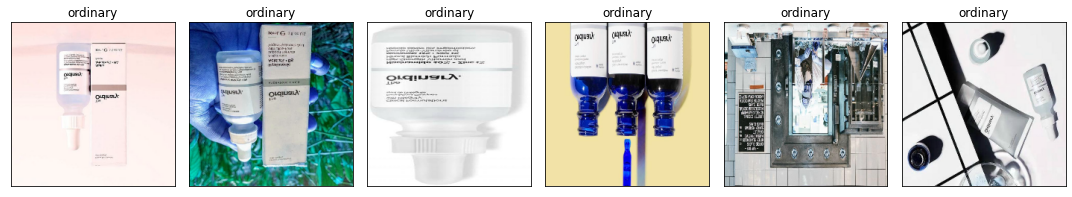

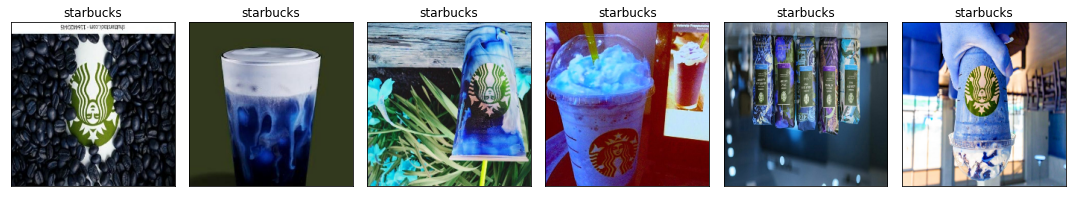

In [8]:
# e see that we have an imbalanced dataset. Hence, we will be using image augmentation techniques to compensate for this.

# Coca_cola images
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(cocacola_train_images[i])
    img = cv2.resize(img, (512,512))
    ax.imshow(img)
    ax.set_title("Coca_cola")  
plt.show()

# Pepsi images
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(pepsi_train_images[i])
    img = cv2.resize(img, (220,220))
    ax.imshow(img)
    ax.set_title("Pepsi")
fig.tight_layout()    
plt.show()

# lactania images
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(lactania_train_images[i])
    img = cv2.resize(img, (220,220))
    ax.imshow(img)
    ax.set_title("lactania")
fig.tight_layout()    
plt.show()

# ordinary images
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(ordinary_train_images[i])
    img = cv2.resize(img, (220,220))
    ax.imshow(img)
    ax.set_title("ordinary")
fig.tight_layout()    
plt.show()

# starbucks images
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(starbucks_train_images[i])
    img = cv2.resize(img, (220,220))
    ax.imshow(img)
    ax.set_title("starbucks")
fig.tight_layout()    
plt.show()

## Data Augmenatation

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
train_datagen = ImageDataGenerator(rescale=1./255,)
val_datagen = ImageDataGenerator(rescale = 1./255.,)
# test_datagen = ImageDataGenerator(rescale = 1./255.,)


train_generator = train_datagen.flow_from_directory(train_dir, batch_size=20, class_mode='binary', target_size = (220, 220))
validation_generator = val_datagen.flow_from_directory(test_dir, batch_size=20, class_mode = 'binary', target_size=(220, 220))


Found 2140 images belonging to 5 classes.
Found 78 images belonging to 5 classes.


In [10]:
train_generator.class_indices

{'cocacola': 0, 'lactania': 1, 'ordinary': 2, 'pepsi': 3, 'starbucks': 4}

## Upload Data In s3

In [11]:
import sagemaker
sess = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sess.default_bucket()

# prefix = 'brand-classification'
# training_input_path   = sess.upload_data('./train', key_prefix=prefix+'/training')
# validation_input_path = sess.upload_data('./test', key_prefix=prefix+'/validation')
# s3_output = 's3://{}/{}/output/'.format(bucket, prefix)

In [12]:
training_input_path = 's3://sagemaker-us-east-1-212675305774/brand-classification/training'
validation_input_path = 's3://sagemaker-us-east-1-212675305774/brand-classification/validation'
s3_output = 's3://sagemaker-us-east-1-212675305774/brand-classification/output/'
print(training_input_path)
print(validation_input_path)
print(s3_output)

s3://sagemaker-us-east-1-212675305774/brand-classification/training
s3://sagemaker-us-east-1-212675305774/brand-classification/validation
s3://sagemaker-us-east-1-212675305774/brand-classification/output/


## Start Training job

In [17]:
from sagemaker.tensorflow import TensorFlow
from keras.preprocessing import image
import time
# install dependecies in tensorflow container.
env = {
    'SAGEMAKER_REQUIREMENTS': 'requirements.txt', # path relative to `source_dir` below.
}

#hyperperameter tuining
hyperparameters={'epochs': 5,
                 'batch-size': 32} 

tf_estimator = TensorFlow(entry_point='train.py',
                          source_dir='src',
                          role=role,
                          instance_count=1, 
                          instance_type='ml.m5.xlarge',     # $0.922 per hours
                          framework_version='2.3', 
                          py_version='py37',
                          output_path=s3_output,
                          script_mode=True,
                          hyperparameters = hyperparameters)

In [18]:
tf_estimator.hyperparameters()

{'epochs': '5', 'batch-size': '32', 'model_dir': 'null'}

In [19]:
tf_estimator.fit({'training':training_input_path, 'validation':validation_input_path})

2022-11-28 08:38:43 Starting - Starting the training job...
2022-11-28 08:39:07 Starting - Preparing the instances for trainingProfilerReport-1669624723: InProgress
......
2022-11-28 08:40:14 Downloading - Downloading input data...
2022-11-28 08:40:39 Training - Downloading the training image......
2022-11-28 08:41:35 Training - Training image download completed. Training in progress..2022-11-28 08:41:37.661440: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-11-28 08:41:37.666025: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2022-11-28 08:41:37.876720: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-11-28 08:41:41,213 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2022-11-28 08:41:41,

## Deploy Model

In [16]:
%%time
tf_endpoint_name = 'snapCycle-'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

#tf_predictor = tf_estimator.deploy(initial_instance_count=1,
#                                   instance_type='ml.p2.xlarge')      # $1.361/hour 

tf_predictor = tf_estimator.deploy(initial_instance_count=1,
                                   instance_type='ml.t2.medium',        # $0.115/hour 
                                   endpoint_name=tf_endpoint_name) 

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-------!CPU times: user 172 ms, sys: 10.4 ms, total: 183 ms
Wall time: 3min 31s


## Prediction

{'cocacola': 0, 'lactania': 1, 'ordinary': 2, 'pepsi': 3, 'starbucks': 4}

In [39]:
cd /home/ec2-user/SageMaker/brandClassification

/home/ec2-user/SageMaker/brandClassification


In [52]:
from keras.preprocessing import image
cocacola='test/cocacola/146_jpg.rf.435628b3a792d5282e20fe9d2a7c8dcb.jpg'
pepsi='test/pepsi/199_jpg.rf.495e79d45b1191e66e9db6845fbf46c7.jpg'
starbucks = 'test/starbucks/starbuckscoffee183_jpeg.rf.76354d87e2f6086ec2ab672253f97814.jpg'
# pepsi = 'pepsi.jpg'
# coca_cola = 'coca_cola.png'

In [53]:
# img=image.load_img(starbucks, target_size=(220, 220))
img=image.load_img(cocacola,target_size=(220, 220))
x = np.asarray(img) / 255
x=np.expand_dims(x, axis=0)
images = np.vstack([x])

In [54]:
%%time
predictions2 =tf_predictor.predict(x)
prediction = np.array(predictions2['predictions'])
predicted_label = prediction.argmax(axis=1)
print(predictions2)
print(predicted_label)

{'predictions': [[0.955761, 0.00207643677, 4.65691373e-05, 0.0401954167, 0.0019206109]]}
[0]
CPU times: user 94.2 ms, sys: 10.4 ms, total: 105 ms
Wall time: 388 ms


## Prediction using URL

{'cocacola': 0, 'lactania': 1, 'ordinary': 2, 'pepsi': 3, 'starbucks': 4}

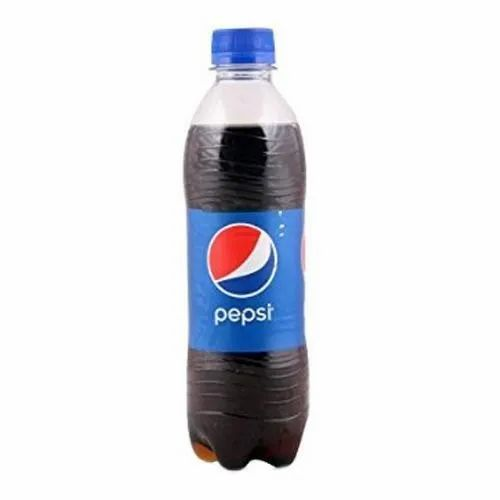

{'predictions': [[0.385332346, 0.0403747857, 0.00424991315, 0.568664372, 0.00137852156]]}
[3]


In [23]:
# load image from url

import urllib.request
from PIL import Image
import requests
from io import BytesIO

url = 'https://5.imimg.com/data5/IL/RQ/LZ/SELLER-107310956/pepsi-cold-drink-500x500.jpg'
response = requests.get(url)
img1 = Image.open(BytesIO(response.content))
# img_new = images(img_main= img1)
img1.save('pepsi.jpg')
img1.show()

coca_colaImage = 'pepsi.jpg'

# preprocess the image
img=image.load_img(coca_colaImage, target_size=(220, 220))
x = np.asarray(img) / 255
x=np.expand_dims(x, axis=0)
images = np.vstack([x])

# predict the image
predictions2 =tf_predictor.predict(x)
prediction = np.array(predictions2['predictions'])
predicted_label = prediction.argmax(axis=1)
print(predictions2)
print(predicted_label)

## Delete Endpoint

In [24]:
tf_predictor.delete_endpoint()

In [ ]:
# import os
# import io
# import boto3
# import json
# import pandas as pd
# import numpy as np

# # grab environment variables
# ENDPOINT_NAME = os.environ['ENDPOINT_NAME']
# runtime= boto3.client('runtime.sagemaker')

# def lambda_handler(event, context):
#     print("Received event: " + json.dumps(event, indent=2))
    
#     data1 = json.loads(json.dumps(event))
#     data = pd.DataFrame (data1, columns = ['RSRP', 'RSSI', 'RSRQ'])
#     data.abs()
#     payload = data1['data']
#     print(payload)
    
#     response = runtime.invoke_endpoint(EndpointName=ENDPOINT_NAME,
#                                        Body=json.dumps(payload))
#     print(response)
#     result = json.loads(response['Body'].read().decode())
#     print(result)
    
#     return result[0]